# Кодировщик бинов
Третье необязательное ДЗ по курсу ПЗАД 2020.

Выполнил Александр Чернышёв, 517 группа.

Ссылка на реализацию: https://github.com/sasasagagaga/BinsEncoder

## Описание реализации

Я написал два класса: `BinsEncoder` и `BinsDiscretizer`.

### Класс `BinsEncoder` (цель задания)
В этом классе реализована кодировка бинов для вещественного признака.

Каждый бин можно закодировать:
* минимальным значением
* максимальным значением
* средним значением
* медианным значением
* самым популярным значением
* номером бина


### Класс `BinsDiscretizer` (дополнительно, чтобы протестировать класс `BinsEncoder`)
Этот класс позволяет непосредственно сделать биннинг для вещественного признака. Он очень похож на реализацию `KBinsDiscretizer` из `sklearn`.

Поддерживаются следующие стратегии биннинга:
* Equal-width (ширина всех бинов одинакова)
* Equal-depth (количество наблюдений в каждом бине одинаково)
* С помощью кластеризации методом KMeans

## Импорт библиотек

In [1]:
import time
from copy import deepcopy

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from BinsEncoder import BinsEncoder
from BinsDiscretizer import BinsDiscretizer

from sklearn.datasets import fetch_openml

In [2]:
def get_array_for_print(x, fmt='0.1f'):
    x_str = f"{{x:{fmt}}}"
    return f'[{", ".join([x_str.format(x=x) for x in x])}]'
#     return f'[{", ".join([f"{x:0.1f}" for x in x])}]'

## Пример

Возьмем для примера данные со слайда с заданием:

![](hw_description.png)

In [3]:
X = np.array([1, 1, 1, 2, 2, 4, 4, 7, 8, 9], dtype=float)
# np.random.shuffle(X)
print(f'X: {X}')

X: [1. 1. 1. 2. 2. 4. 4. 7. 8. 9.]


## Создадим дискретизатор и преобразуем `X`
Количество бинов: 2.  
Стратегия биннинга: квантильный.  
Стратегия кодирования: среднее значение.

In [4]:
bd = BinsDiscretizer(n_bins=2, strategy='quantile', encode_bins='mean')

In [5]:
print(f'X        : {get_array_for_print(X)}')
print(f'Результат: {get_array_for_print(bd.fit_transform(X))}')

X        : [1.0, 1.0, 1.0, 2.0, 2.0, 4.0, 4.0, 7.0, 8.0, 9.0]
Результат: [1.4, 1.4, 1.4, 1.4, 1.4, 6.4, 6.4, 6.4, 6.4, 6.4]


Как видим, преобразование произведено верно.

Посмотрим дополнительно на получившиеся бины:

In [6]:
labels = bd._get_labels(X)
bins = bd.encoder_._convert_X_to_bins(X, labels)[0]

print(f'X     : {X}')
print(f'labels: {labels}')
print(f'bins  : {bins}')

X     : [1. 1. 1. 2. 2. 4. 4. 7. 8. 9.]
labels: [0 0 0 0 0 1 1 1 1 1]
bins  : [[1.0, 1.0, 1.0, 2.0, 2.0], [4.0, 4.0, 7.0, 8.0, 9.0]]


## Эксперименты

Посмотрим теперь на результаты биннинга при разном количестве бинов, разных стратегиях разбиения значений признака на бины и разных стратегиях кодирования бинов.

In [7]:
def run_experiments(
    X,
    n_bins_vars=range(2, 6),
    discretizer_strategy_vars=tuple(BinsDiscretizer()._strategies.keys()),
    encoder_strategy_vars=tuple(BinsEncoder._strategies.keys()),
    verbose=10
):
    for n_bins in n_bins_vars:
        for discretizer_strategy in discretizer_strategy_vars:
            for encoder_strategy in encoder_strategy_vars:
                bd = BinsDiscretizer(n_bins=n_bins, strategy=discretizer_strategy, encode_bins=encoder_strategy)
                X_enc = bd.fit_transform(X)
                labels = bd._get_labels(X)
                bins_borders = bd.bins_borders_
                bins_encoding = bd.encoder_.bins_encoding_
                bins = bd.encoder_._convert_X_to_bins(X, labels)[0]

                if verbose > 0:
                    print()
                    print(
                        '\t'
                        f'Количество бинов: {n_bins:2}, '
                        f'стратегия дискретизатора: {discretizer_strategy:10}, '
                        f'стратегия кодировщика: {encoder_strategy:10}'
                    )

                if verbose >= 10:
                    print(f'{"X":23}: {get_array_for_print(X)}')
                    print(f'{"Метки бинов":23}: {get_array_for_print(labels, "3d")}')
                    print(f'{"Бины":23}: {bins}')
                if verbose >= 2:
                    print(f'{"Размеры бинов":23}: {[len(b) for b in bins]}')
                    print(f'{"Границы бинов":23}: {get_array_for_print(bins_borders)}')
                    print(f'{"Кодирование для бинов":23}:    {get_array_for_print(bins_encoding)}')
                if verbose >= 10:
                    print(f'{"Результат":23}: {get_array_for_print(X_enc)}')

In [8]:
run_experiments(X)


	Количество бинов:  2, стратегия дискретизатора: uniform   , стратегия кодировщика: min       
X                      : [1.0, 1.0, 1.0, 2.0, 2.0, 4.0, 4.0, 7.0, 8.0, 9.0]
Метки бинов            : [  0,   0,   0,   0,   0,   0,   0,   1,   1,   1]
Бины                   : [[1.0, 1.0, 1.0, 2.0, 2.0, 4.0, 4.0], [7.0, 8.0, 9.0]]
Размеры бинов          : [7, 3]
Границы бинов          : [1.0, 5.0, 9.0]
Кодирование для бинов  :    [1.0, 7.0]
Результат              : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 7.0, 7.0, 7.0]

	Количество бинов:  2, стратегия дискретизатора: uniform   , стратегия кодировщика: max       
X                      : [1.0, 1.0, 1.0, 2.0, 2.0, 4.0, 4.0, 7.0, 8.0, 9.0]
Метки бинов            : [  0,   0,   0,   0,   0,   0,   0,   1,   1,   1]
Бины                   : [[1.0, 1.0, 1.0, 2.0, 2.0, 4.0, 4.0], [7.0, 8.0, 9.0]]
Размеры бинов          : [7, 3]
Границы бинов          : [1.0, 5.0, 9.0]
Кодирование для бинов  :    [4.0, 9.0]
Результат              : [4.0, 4.0, 4.0, 4.0

Вроде все ок.

Теперь перемешаем `X` и проведем те же тесты с ним еще раз:

In [9]:
X = np.array([1, 1, 1, 2, 2, 4, 4, 7, 8, 9], dtype=float)
np.random.shuffle(X)
print(f'X: {X}')

X: [4. 4. 2. 9. 1. 8. 2. 1. 1. 7.]


In [10]:
run_experiments(X)


	Количество бинов:  2, стратегия дискретизатора: uniform   , стратегия кодировщика: min       
X                      : [4.0, 4.0, 2.0, 9.0, 1.0, 8.0, 2.0, 1.0, 1.0, 7.0]
Метки бинов            : [  0,   0,   0,   1,   0,   1,   0,   0,   0,   1]
Бины                   : [[4.0, 4.0, 2.0, 1.0, 2.0, 1.0, 1.0], [9.0, 8.0, 7.0]]
Размеры бинов          : [7, 3]
Границы бинов          : [1.0, 5.0, 9.0]
Кодирование для бинов  :    [1.0, 7.0]
Результат              : [1.0, 1.0, 1.0, 7.0, 1.0, 7.0, 1.0, 1.0, 1.0, 7.0]

	Количество бинов:  2, стратегия дискретизатора: uniform   , стратегия кодировщика: max       
X                      : [4.0, 4.0, 2.0, 9.0, 1.0, 8.0, 2.0, 1.0, 1.0, 7.0]
Метки бинов            : [  0,   0,   0,   1,   0,   1,   0,   0,   0,   1]
Бины                   : [[4.0, 4.0, 2.0, 1.0, 2.0, 1.0, 1.0], [9.0, 8.0, 7.0]]
Размеры бинов          : [7, 3]
Границы бинов          : [1.0, 5.0, 9.0]
Кодирование для бинов  :    [4.0, 9.0]
Результат              : [4.0, 4.0, 4.0, 9.0


	Количество бинов:  3, стратегия дискретизатора: quantile  , стратегия кодировщика: index     
X                      : [4.0, 4.0, 2.0, 9.0, 1.0, 8.0, 2.0, 1.0, 1.0, 7.0]
Метки бинов            : [  2,   2,   1,   2,   0,   2,   1,   0,   0,   2]
Бины                   : [[1.0, 1.0, 1.0], [2.0, 2.0], [4.0, 4.0, 9.0, 8.0, 7.0]]
Размеры бинов          : [3, 2, 5]
Границы бинов          : [1.0, 2.0, 4.0, 9.0]
Кодирование для бинов  :    [1.0, 2.0, 3.0]
Результат              : [3.0, 3.0, 2.0, 3.0, 1.0, 3.0, 2.0, 1.0, 1.0, 3.0]

	Количество бинов:  3, стратегия дискретизатора: kmeans    , стратегия кодировщика: min       
X                      : [4.0, 4.0, 2.0, 9.0, 1.0, 8.0, 2.0, 1.0, 1.0, 7.0]
Метки бинов            : [  1,   1,   0,   2,   0,   2,   0,   0,   0,   2]
Бины                   : [[2.0, 1.0, 2.0, 1.0, 1.0], [4.0, 4.0], [9.0, 8.0, 7.0]]
Размеры бинов          : [5, 2, 3]
Границы бинов          : [1.0, 2.7, 6.0, 9.0]
Кодирование для бинов  :    [1.0, 4.0, 7.0]
Результат     


	Количество бинов:  4, стратегия дискретизатора: kmeans    , стратегия кодировщика: median    
X                      : [4.0, 4.0, 2.0, 9.0, 1.0, 8.0, 2.0, 1.0, 1.0, 7.0]
Метки бинов            : [  1,   1,   0,   3,   0,   3,   0,   0,   0,   2]
Бины                   : [[2.0, 1.0, 2.0, 1.0, 1.0], [4.0, 4.0], [7.0], [9.0, 8.0]]
Размеры бинов          : [5, 2, 1, 2]
Границы бинов          : [1.0, 2.7, 5.5, 7.8, 9.0]
Кодирование для бинов  :    [1.0, 4.0, 7.0, 8.5]
Результат              : [4.0, 4.0, 1.0, 8.5, 1.0, 8.5, 1.0, 1.0, 1.0, 7.0]

	Количество бинов:  4, стратегия дискретизатора: kmeans    , стратегия кодировщика: mode      
X                      : [4.0, 4.0, 2.0, 9.0, 1.0, 8.0, 2.0, 1.0, 1.0, 7.0]
Метки бинов            : [  1,   1,   0,   3,   0,   3,   0,   0,   0,   2]
Бины                   : [[2.0, 1.0, 2.0, 1.0, 1.0], [4.0, 4.0], [7.0], [9.0, 8.0]]
Размеры бинов          : [5, 2, 1, 2]
Границы бинов          : [1.0, 2.7, 5.5, 7.8, 9.0]
Кодирование для бинов  :    [1.0,

Вроде все ок.

Теперь посмотрим именно на работу кодировщика бинов:

In [11]:
bins = [
    [1, 1, 1, 2, 2],
    [4, 4, 7, 8, 9],
]

In [12]:
for strategy in BinsEncoder._strategies:
    print()
    print(strategy)
    be = BinsEncoder(strategy)
    be.fit(bins)
    print(be.bins_encoding_)
    print(be.transform(bins))


min
[1. 4.]
[array([1., 1., 1., 1., 1.]), array([4., 4., 4., 4., 4.])]

max
[2. 9.]
[array([2., 2., 2., 2., 2.]), array([9., 9., 9., 9., 9.])]

mean
[1.4 6.4]
[array([1.4, 1.4, 1.4, 1.4, 1.4]), array([6.4, 6.4, 6.4, 6.4, 6.4])]

median
[1. 7.]
[array([1., 1., 1., 1., 1.]), array([7., 7., 7., 7., 7.])]

mode
[1. 4.]
[array([1., 1., 1., 1., 1.]), array([4., 4., 4., 4., 4.])]

index
[1. 2.]
[array([1., 1., 1., 1., 1.]), array([2., 2., 2., 2., 2.])]


Все хорошо :)

Так что вроде бы оба класса работают правильно.

## Время работы кодировщика

Для измерения времени работы кодировщика возьмем датасет MNIST (70 000 объектов) и запустим кодировщик бинов на каждом признаке.

In [13]:
mnist = fetch_openml('mnist_784')
X = deepcopy(mnist.data)
X.shape

(70000, 784)

In [14]:
X = deepcopy(mnist.data)

In [15]:
bd = BinsDiscretizer(n_bins=10, encode_bins='mean', strategy='quantile')

start_time = time.time()
for i in tqdm(range(X.shape[1])):
    X[:, i] = bd.fit_transform(X[:, i])
end_time = time.time()

print(f'Время обработки {X.shape[1]} признаков: {end_time - start_time:0.1f} секунд.')
print(f'В среднем {(end_time - start_time) / X.shape[1]:0.1f} секунд на 1 признак.')


Время обработки 784 признаков: 64.7 секунд.
В среднем 0.1 секунд на 1 признак.


Посмотрим еще просто на вывод:

In [16]:
run_experiments(X[:, 784 // 2 + 14], [10], ['quantile'], ['mean'], verbose=2)


	Количество бинов: 10, стратегия дискретизатора: quantile  , стратегия кодировщика: mean      
Размеры бинов          : [0, 0, 0, 27946, 7037, 6939, 4467, 3529, 10114, 9968]
Границы бинов          : [3.5, 3.5, 3.5, 3.5, 96.3, 189.0, 240.3, 252.0, 253.0, 254.3, 254.3]
Кодирование для бинов  :    [3.5, 3.5, 3.5, 3.5, 96.3, 189.0, 240.3, 252.0, 253.0, 254.3]


Как видим, иногда бины получаются пустыми (по наблюдениям, этим страдают чаще всего стратегии разбиения на бины equal-width и equal-depth).

## Датасет Titanic

Попробуем закодировать признак возраста в датасете Titanic.

In [17]:
titanic_train = pd.read_csv('https://raw.githubusercontent.com/antonfefilov/titanic/master/input/train.csv')
titanic_test = pd.read_csv('https://raw.githubusercontent.com/antonfefilov/titanic/master/input/test.csv')

In [18]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 16

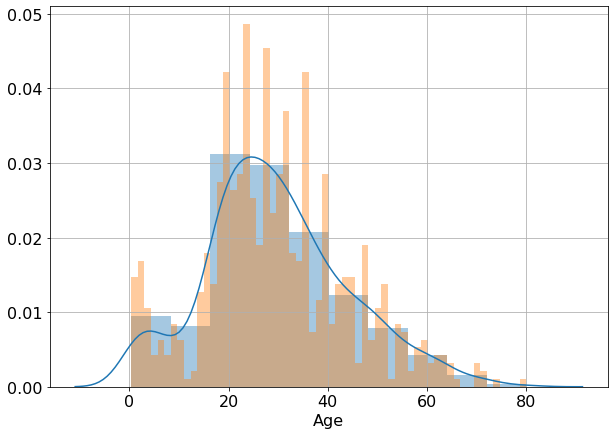

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.distplot(titanic_train.Age, bins=10, kde=True, norm_hist=True, ax=ax)
sns.distplot(titanic_train.Age, bins=60, kde=False, norm_hist=True, ax=ax)

plt.grid(True)

Разобъем признак возраста на 10 бинов:

In [21]:
mask_not_nan = ~titanic_train.Age.isna()

In [22]:
bd = BinsDiscretizer(n_bins=10, encode_bins='mean', strategy='quantile')
titanic_train.loc[mask_not_nan, 'Age_binned'] = bd.fit_transform(titanic_train[mask_not_nan].Age)

In [27]:
mask_not_nan = ~titanic_test.Age.isna()
titanic_test.loc[mask_not_nan, 'Age_binned'] = bd.transform(titanic_test[mask_not_nan].Age)

In [23]:
titanic_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_binned
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23.067568
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,37.905797
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,25.915254
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,33.485507
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,33.485507
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,25.915254
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,19.992308
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,25.915254


In [28]:
titanic_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_binned
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,33.485507
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,44.878378
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,57.540541
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,25.915254
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,23.067568
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,37.905797
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,37.905797
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN


In [24]:
bd.bins_borders_

array([ 0.42, 14.  , 19.  , 22.  , 25.  , 28.  , 31.8 , 36.  , 41.  ,
       50.  , 80.  ])

In [25]:
titanic_train.Age_binned.values

array([23.06756757, 37.9057971 , 25.91525424, 33.48550725, 33.48550725,
               nan, 57.54054054,  5.00239437, 25.91525424, 16.68382353,
        5.00239437, 57.54054054, 19.99230769, 37.9057971 , 16.68382353,
       57.54054054,  5.00239437,         nan, 29.3956044 ,         nan,
       33.48550725, 33.48550725, 16.68382353, 29.3956044 ,  5.00239437,
       37.9057971 ,         nan, 19.99230769,         nan,         nan,
       37.9057971 ,         nan,         nan, 57.54054054, 29.3956044 ,
       44.87837838,         nan, 19.99230769, 16.68382353, 16.68382353,
       37.9057971 , 25.91525424,         nan,  5.00239437, 19.99230769,
               nan,         nan,         nan,         nan, 16.68382353,
        5.00239437, 19.99230769, 44.87837838, 29.3956044 , 57.54054054,
               nan, 19.99230769, 29.3956044 ,  5.00239437,  5.00239437,
       23.06756757, 37.9057971 , 44.87837838,  5.00239437,         nan,
               nan, 29.3956044 , 19.99230769, 16.68382353, 25.91

In [29]:
titanic_test.Age_binned.values

array([33.48550725, 44.87837838, 57.54054054, 25.91525424, 23.06756757,
       16.68382353, 29.3956044 , 25.91525424, 16.68382353, 19.99230769,
               nan, 44.87837838, 23.06756757, 57.54054054, 44.87837838,
       23.06756757, 33.48550725, 19.99230769, 25.91525424, 44.87837838,
       57.54054054,  5.00239437,         nan, 19.99230769, 44.87837838,
       57.54054054, 23.06756757, 23.06756757, 44.87837838,         nan,
       57.54054054, 23.06756757, 33.48550725,         nan, 29.3956044 ,
       16.68382353,         nan, 19.99230769, 25.91525424,         nan,
       37.9057971 ,         nan, 44.87837838, 29.3956044 , 44.87837838,
       25.91525424, 44.87837838,         nan, 57.54054054, 37.9057971 ,
       23.06756757, 25.91525424, 19.99230769, 29.3956044 ,         nan,
        5.00239437, 33.48550725, 25.91525424,         nan, 37.9057971 ,
       16.68382353, 33.48550725, 16.68382353, 23.06756757,  5.00239437,
               nan, 16.68382353, 44.87837838, 29.3956044 , 57.54

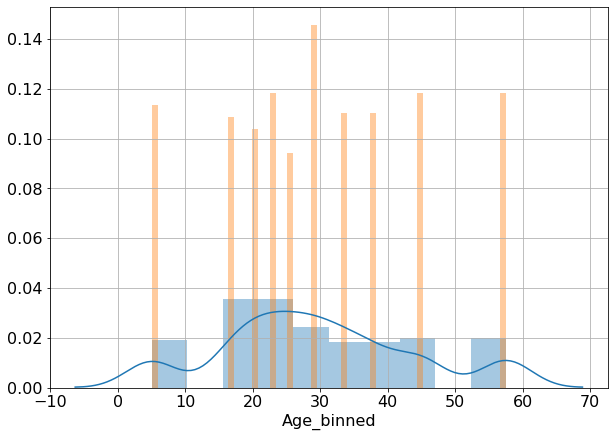

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.distplot(titanic_train.Age_binned, bins=10, kde=True, norm_hist=True, ax=ax)
sns.distplot(titanic_train.Age_binned, bins=60, kde=False, norm_hist=True, ax=ax)

plt.grid(True)

Биннинг прошел успешно!